In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker

from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost.sklearn import XGBClassifier

In [2]:
#load data 
world_cup = pd.read_csv('datasets/World Cup 2018 Dataset.csv')
results = pd.read_csv('datasets/results.csv')

In [3]:
# data cleaning - there are some typos in the data ;-)
world_cup = world_cup.replace({"IRAN": "Iran",
                               "Costarica": "Costa Rica",
                               "Porugal": "Portugal",
                               "Columbia": "Colombia",
                               "Korea" : "Korea Republic"})

results =  results.replace({'Germany DR': 'Germany', 'China': 'China PR'})

In [4]:
world_cup.head()

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Portugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


In [5]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


In [6]:
#Adding goal difference and establishing who is the winner 
winner = []
for i in range (len(results['home_team'])):
    if results ['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results ['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Draw')
results['winning_team'] = winner

#adding goal difference column
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()


,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


In [7]:
#lets work with a subset of the data one that includes games played by Nigeria in a Nigeria dataframe
df = results[(results['home_team'] == 'Germany') | (results['away_team'] == 'Germany')]
filtered = df.iloc[:]
filtered.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
38609,2017-11-10,England,Germany,0,0,Friendly,London,England,Draw,0
38678,2017-11-14,Germany,France,2,2,Friendly,Cologne,Germany,Draw,0
38792,2018-03-23,Germany,Spain,1,1,Friendly,Düsseldorf,Germany,Draw,0
38865,2018-03-27,Germany,Brazil,0,1,Friendly,Berlin,Germany,Brazil,1
38911,2018-06-17,Germany,Mexico,0,1,FIFA World Cup,Luzhniki,Russia,Mexico,1


In [8]:
#creating a column for year and the first world cup was held in 1930
year = []
for row in filtered['date']:
    year.append(int(row[:4]))
filtered ['match_year']= year
filtered_1930 = filtered[filtered.match_year >= 1930]
filtered_1930.count()

date               864
home_team          864
away_team          864
home_score         864
away_score         864
tournament         864
city               864
country            864
winning_team       864
goal_difference    864
match_year         864
dtype: int64

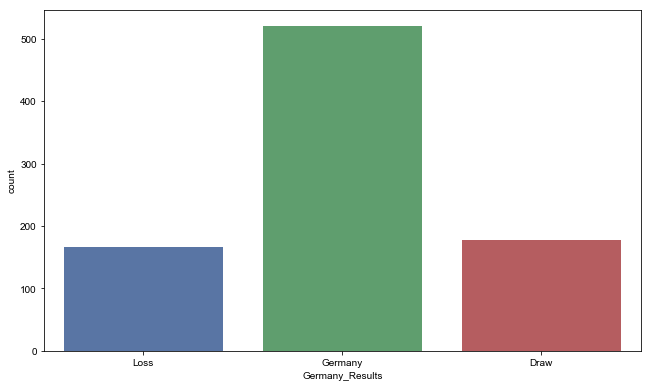

In [9]:
#what is the common game outcome for germany visualisation
wins = []
for row in filtered_1930['winning_team']:
    if row != 'Germany' and row != 'Draw':
        wins.append('Loss')
    else:
        wins.append(row)
winsdf= pd.DataFrame(wins, columns=[ 'Germany_Results'])

#plotting
fig, ax = plt.subplots(1)
fig.set_size_inches(10.7, 6.27)
sns.set(style='darkgrid')
sns.countplot(x='Germany_Results', data=winsdf)

In [10]:
# wins is a good metric to analyze and predict outcomes of matches in the tournament 
#tournament and venue won't add much to our predictions
#historical match records will be used 


In [11]:
#narrowing to team patcipating in the world cup
worldcup_teams = ['Australia', ' Iran', 'Japan', 'Korea Republic', 
            'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria', 
            'Senegal', 'Tunisia', 'Costa Rica', 'Mexico', 
            'Panama', 'Argentina', 'Brazil', 'Colombia', 
            'Peru', 'Uruguay', 'Belgium', 'Croatia', 
            'Denmark', 'England', 'France', 'Germany', 
            'Iceland', 'Poland', 'Portugal', 'Russia', 
            'Serbia', 'Spain', 'Sweden', 'Switzerland']
df_teams_home = results[results['home_team'].isin(worldcup_teams)]
df_teams_away = results[results['away_team'].isin(worldcup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()
df_teams.count()

date               20584
home_team          20584
away_team          20584
home_score         20584
away_score         20584
tournament         20584
city               20584
country            20584
winning_team       20584
goal_difference    20584
dtype: int64

In [12]:
df_teams.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
38907,2018-06-16,Argentina,Iceland,1,1,FIFA World Cup,Moscow,Russia,Draw,0
38908,2018-06-16,Peru,Denmark,0,1,FIFA World Cup,Saransk,Russia,Denmark,1
38909,2018-06-16,Croatia,Nigeria,2,0,FIFA World Cup,Kaliningrad,Russia,Croatia,2
38910,2018-06-17,Costa Rica,Serbia,0,1,FIFA World Cup,Samara,Russia,Serbia,1
38911,2018-06-17,Germany,Mexico,0,1,FIFA World Cup,Luzhniki,Russia,Mexico,1


In [13]:
#create an year column to drop games before 1930
year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year
df_teams_after_1930 = df_teams[df_teams.match_year >= 1930]
df_teams_after_1930.head()



,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
1230,1930-01-01,Spain,Czechoslovakia,1,0,Friendly,Barcelona,Spain,Spain,1,1930
1231,1930-01-12,Portugal,Czechoslovakia,1,0,Friendly,Lisbon,Portugal,Portugal,1,1930
1237,1930-02-23,Portugal,France,2,0,Friendly,Porto,Portugal,Portugal,2,1930
1238,1930-03-02,Germany,Italy,0,2,Friendly,Frankfurt am Main,Germany,Italy,2,1930
1240,1930-03-23,France,Switzerland,3,3,Friendly,Colombes,France,Draw,0,1930


In [14]:
#dropping columns that wll not affect matchoutcomes
df_teams_after_1930 = df_teams.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country', 'goal_difference', 'match_year'], axis=1)
df_teams_after_1930.tail()

,home_team,away_team,winning_team
38907,Argentina,Iceland,Draw
38908,Peru,Denmark,Denmark
38909,Croatia,Nigeria,Croatia
38910,Costa Rica,Serbia,Serbia
38911,Germany,Mexico,Mexico


In [15]:
#Building the model
#the prediction label: The winning_team column will show "2" if the home team has won, "1" if it was a tie, and "0" if the away team has won.

df_teams_after_1930 = df_teams_after_1930.reset_index(drop=True)
df_teams_after_1930.loc[df_teams_after_1930.winning_team == df_teams_after_1930.home_team,'winning_team']=2
df_teams_after_1930.loc[df_teams_after_1930.winning_team == 'Draw', 'winning_team']=1
df_teams_after_1930.loc[df_teams_after_1930.winning_team == df_teams_after_1930.away_team, 'winning_team']=0

df_teams_after_1930.tail()

,home_team,away_team,winning_team
20579,Argentina,Iceland,1
20580,Peru,Denmark,0
20581,Croatia,Nigeria,2
20582,Costa Rica,Serbia,0
20583,Germany,Mexico,0


In [16]:
#convert home team and away team from categorical variables to continous inputs 
# Get dummy variables
final = pd.get_dummies(df_teams_after_1930, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
final.tail()

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
20579,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20581,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
xgbclas = XGBClassifier()
xgbclas.fit(X_train, y_train)

y_pred = xgbclas.predict(X_test)
score = cross_val_score(xgbclas, X_train, y_train)

#test_score = accuracy_score(y_test, y_pred)

print("Cross-validation accuracy: ", '%.3f'%(np.mean(score)))

C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cross-validation accuracy:  0.518


C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
#adding Fifa rankings
#the team which is positioned higher on the FIFA Ranking will be considered "favourite" for the match
#and therefore, will be positioned under the "home_teams" column
#since there are no "home" or "away" teams in World Cup games. 

# Loading new datasets
ranking = pd.read_csv('datasets/fifa_rankings.csv') 
fixtures = pd.read_csv('datasets/fixtures.csv')

# List for storing the group stage games
pred_set = []

In [20]:
# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

,Round Number,first_position,second_position,Date,Location,Home Team,Away Team,Group,Result
43,3,6.0,23.0,27/06/2018 21:00,Nizhny Novgorod Stadium,Switzerland,Costa Rica,Group E,NaN
44,3,61.0,8.0,28/06/2018 17:00,Volgograd Stadium,Japan,Poland,Group H,NaN
45,3,27.0,16.0,28/06/2018 17:00,Samara Stadium,Senegal,Colombia,Group H,NaN
46,3,55.0,21.0,28/06/2018 21:00,Saransk Stadium,Panama,Tunisia,Group G,NaN
47,3,13.0,3.0,28/06/2018 21:00,Kaliningrad Stadium,England,Belgium,Group G,NaN


In [21]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,away_team,home_team,winning_team
0,Russia,Saudi Arabia,None
1,Egypt,Uruguay,None
2,Morocco,Iran,None
3,Spain,Portugal,None
4,Australia,France,None


In [22]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,home_team_Austria,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#group matches 
predictions = xgbclas.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 1:
        print("Draw")
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 0])
    print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(xgbclas.predict_proba(pred_set)[i][2]))
    print('Probability of Draw: ', '%.3f'%(xgbclas.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(xgbclas.predict_proba(pred_set)[i][0]))
    print("")

C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Saudi Arabia and Russia
Winner: Saudi Arabia
Probability of Saudi Arabia winning:  0.359
Probability of Draw:  0.296
Probability of Russia winning:  0.345

Uruguay and Egypt
Winner: Uruguay
Probability of Uruguay winning:  0.442
Probability of Draw:  0.341
Probability of Egypt winning:  0.217

Iran and Morocco
Winner: Iran
Probability of Iran winning:  0.443
Probability of Draw:  0.297
Probability of Morocco winning:  0.260

Portugal and Spain
Winner: Portugal
Probability of Portugal winning:  0.361
Probability of Draw:  0.330
Probability of Spain winning:  0.309

France and Australia
Winner: France
Probability of France winning:  0.524
Probability of Draw:  0.217
Probability of Australia winning:  0.259

Argentina and Iceland
Winner: Argentina
Probability of Argentina winning:  0.669
Probability of Draw:  0.190
Probability of Iceland winning:  0.141

Peru and Denmark
Winner: Peru
Probability of Peru winning:  0.497
Probability of Draw:  0.220
Probability of Denmark winning:  0.284

Cr

In [24]:
# List of tuples before 
group_16 = [('Uruguay', 'Portugal'),
            ('France', 'Croatia'),
            ('Brazil', 'Mexico'),
            ('England', 'Colombia'),
            ('Spain', 'Russia'),
            ('Argentina', 'Peru'),
            ('Germany', 'Switzerland'),
            ('Poland', 'Belgium')]

In [25]:
def clean_and_predict(matches, ranking, final, xgbclas):

    # Initialization of auxiliary list for data cleaning
    positions = []

    # Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])
    
    # Creating the DataFrame for prediction
    pred_set = []

    # Initializing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'positions' list, and 'j' for the list of matches (list of tuples)
    while i < len(positions):
        dict1 = {}

        # If position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        # Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    # Convert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    # Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    # Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    # Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    # Predict!
    predictions = xgbclas.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 1])
        elif predictions[i] == 1:
            print("Draw")
        elif predictions[i] == 0:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ' , '%.3f'%(xgbclas.predict_proba(pred_set)[i][2]))
        print('Probability of Draw: ', '%.3f'%(xgbclas.predict_proba(pred_set)[i][1])) 
        print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(xgbclas.predict_proba(pred_set)[i][0]))
        print("")

In [26]:
clean_and_predict(group_16, ranking, final, xgbclas)

Portugal and Uruguay
Winner: Portugal
Probability of Portugal winning:  0.463
Probability of Draw:  0.237
Probability of Uruguay winning:  0.300

France and Croatia
Winner: France
Probability of France winning:  0.456
Probability of Draw:  0.247
Probability of Croatia winning:  0.296

Brazil and Mexico
Winner: Brazil
Probability of Brazil winning:  0.595
Probability of Draw:  0.225
Probability of Mexico winning:  0.180

England and Colombia
Winner: England
Probability of England winning:  0.518
Probability of Draw:  0.309
Probability of Colombia winning:  0.173

Spain and Russia
Winner: Spain
Probability of Spain winning:  0.519
Probability of Draw:  0.246
Probability of Russia winning:  0.235

Argentina and Peru
Winner: Argentina
Probability of Argentina winning:  0.633
Probability of Draw:  0.218
Probability of Peru winning:  0.148

Germany and Switzerland
Winner: Germany
Probability of Germany winning:  0.580
Probability of Draw:  0.207
Probability of Switzerland winning:  0.213

Be

C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
# List of matches
quarters = [('Portugal', 'France'),
            ('Spain', 'Argentina'),
            ('Brazil', 'England'),
            ('Germany', 'Belgium')]

In [28]:
clean_and_predict(quarters, ranking, final, xgbclas)

Portugal and France
Winner: Portugal
Probability of Portugal winning:  0.466
Probability of Draw:  0.234
Probability of France winning:  0.300

Argentina and Spain
Winner: Argentina
Probability of Argentina winning:  0.528
Probability of Draw:  0.258
Probability of Spain winning:  0.213

Brazil and England
Winner: Brazil
Probability of Brazil winning:  0.502
Probability of Draw:  0.240
Probability of England winning:  0.258

Germany and Belgium
Winner: Germany
Probability of Germany winning:  0.580
Probability of Draw:  0.207
Probability of Belgium winning:  0.213



C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
# List of matches
semi = [('Portugal', 'Brazil'),
        ('Argentina', 'Germany')]

In [30]:
clean_and_predict(semi, ranking, final, xgbclas)

Brazil and Portugal
Winner: Brazil
Probability of Brazil winning:  0.675
Probability of Draw:  0.178
Probability of Portugal winning:  0.147

Germany and Argentina
Winner: Germany
Probability of Germany winning:  0.453
Probability of Draw:  0.251
Probability of Argentina winning:  0.296



C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
# Finals
finals = [('Brazil', 'Germany')]

In [32]:
clean_and_predict(finals, ranking, final, xgbclas)

Germany and Brazil
Winner: Brazil
Probability of Germany winning:  0.342
Probability of Draw:  0.200
Probability of Brazil winning:  0.457



C:\Users\Roman\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
